# SVC

---
<a name="0"/>

### Зміст:

* 1. [Імпорт даних](#1)
* 2. [Первинний аналіз](#2)
* 3. [Фіча інжинірінг](#3)
* 4. [Маштабування фіч](#4)
* 5. [Поділ датасету на train, test](#5)
* 6. [Тренування базової моделі(гіперпараметри=дефолтні)](#6)
* 7. [Підбір гіперпараметрів](#7)
* 8. [Оцінка результатів](#8)

---
Імпортування бібліотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

---
Загальні налаштування

In [2]:
# Налаштуваня візуалізація
sns.set()
%config InlineBackend.figure_format = 'svg'

# Ігнорування помилок при побудові моделі
warnings.filterwarnings("ignore")

---
<a name="1"/>

### 1. Імпорт даних
[зміст](#0)

Маємо 2 датасети з тренувальними і тестовими даними рукописного тексту.

In [3]:
url = 'https://archive.ics.uci.edu/static/public/80/optical+recognition+of+handwritten+digits.zip'

In [4]:
atr_name = []
for i in range(1,65):
    atr_name.append(f"Attribute{i}")
atr_name.append('class')

In [5]:
resp = urlopen(url)
myzip = ZipFile(BytesIO(resp.read()))
with myzip.open('optdigits.tra') as myfile:
    data_train = pd.read_csv(myfile, delimiter=',', names=atr_name)

with myzip.open('optdigits.tes') as myfile:
    data_test = pd.read_csv(myfile, delimiter=',', names=atr_name)

In [6]:
data_train.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64,class
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [7]:
data_train.shape

(3823, 65)

In [8]:
data_test.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [9]:
data_test.shape

(1797, 65)

Опис датасету:

| Назва фічі    |Опис           |Тип            |
|---            |---            |---
| Attribute1-64            | Характеристика пікселя зображеня від 0 до 16.             | номінативні
| class | цифра від 0 до 9 (target)| категорыальна

Для подальшої роботи з даними, дослідження, перетвореня та розділ на `train, valid, test` в тій пропорції що нам треба -  об'єднаємо два датасети.

In [10]:
data = pd.concat([data_train, data_test], axis=0)

In [11]:
data.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64,class
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [12]:
data.shape

(5620, 65)

---
<a name="2"/>

### 2. Первинний аналіз
[зміст](#0)

Перевірка дублікатів

In [13]:
data.duplicated().sum()

0

Баланс класів

In [14]:
data['class'].value_counts()

3    572
1    571
4    568
7    566
9    562
6    558
5    558
2    557
0    554
8    554
Name: class, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5620 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Attribute1   5620 non-null   int64
 1   Attribute2   5620 non-null   int64
 2   Attribute3   5620 non-null   int64
 3   Attribute4   5620 non-null   int64
 4   Attribute5   5620 non-null   int64
 5   Attribute6   5620 non-null   int64
 6   Attribute7   5620 non-null   int64
 7   Attribute8   5620 non-null   int64
 8   Attribute9   5620 non-null   int64
 9   Attribute10  5620 non-null   int64
 10  Attribute11  5620 non-null   int64
 11  Attribute12  5620 non-null   int64
 12  Attribute13  5620 non-null   int64
 13  Attribute14  5620 non-null   int64
 14  Attribute15  5620 non-null   int64
 15  Attribute16  5620 non-null   int64
 16  Attribute17  5620 non-null   int64
 17  Attribute18  5620 non-null   int64
 18  Attribute19  5620 non-null   int64
 19  Attribute20  5620 non-null   int64
 20  Attribut

In [16]:
data.describe(include='all')

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60,Attribute61,Attribute62,Attribute63,Attribute64,class
count,5620.0,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,...,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000,5620.000000
mean,0.0,0.302135,5.393238,11.815480,11.578292,5.593772,1.379359,0.138256,0.003203,1.971174,...,0.166904,0.000356,0.281851,5.760498,11.989680,11.572420,6.720819,2.093594,0.254093,4.495196
std,0.0,0.879962,4.672719,4.255952,4.462546,5.631149,3.356633,1.046998,0.090423,3.098815,...,0.843455,0.018863,0.929969,5.021145,4.347542,4.975675,5.815564,4.047959,1.418558,2.868131
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,10.000000,9.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,5.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,13.000000,13.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,10.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,15.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,5.000000,16.000000,...,13.000000,1.000000,10.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


В датасеті немає дублікатів. Класи сбалансовані. Немає пропущєних значень. Т.я. фічі `Attribute1-64` номінативні з найбільшим значеням 16 - перетворимо їх в `int16` для поліпшеня роботи. class - перетворемо на `category`.

In [17]:
for i in range(1,65):
    feature_name = f"Attribute{i}"
    data[feature_name] = data[feature_name].astype('int16')

data['class'] = data['class'].astype('category')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5620 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Attribute1   5620 non-null   int16   
 1   Attribute2   5620 non-null   int16   
 2   Attribute3   5620 non-null   int16   
 3   Attribute4   5620 non-null   int16   
 4   Attribute5   5620 non-null   int16   
 5   Attribute6   5620 non-null   int16   
 6   Attribute7   5620 non-null   int16   
 7   Attribute8   5620 non-null   int16   
 8   Attribute9   5620 non-null   int16   
 9   Attribute10  5620 non-null   int16   
 10  Attribute11  5620 non-null   int16   
 11  Attribute12  5620 non-null   int16   
 12  Attribute13  5620 non-null   int16   
 13  Attribute14  5620 non-null   int16   
 14  Attribute15  5620 non-null   int16   
 15  Attribute16  5620 non-null   int16   
 16  Attribute17  5620 non-null   int16   
 17  Attribute18  5620 non-null   int16   
 18  Attribute19  5620 non-null  

---
<a name="3"/>

### 3. Фіча інжинірінг
[зміст](#0)

Побудуємо гістограму росподілу фіч

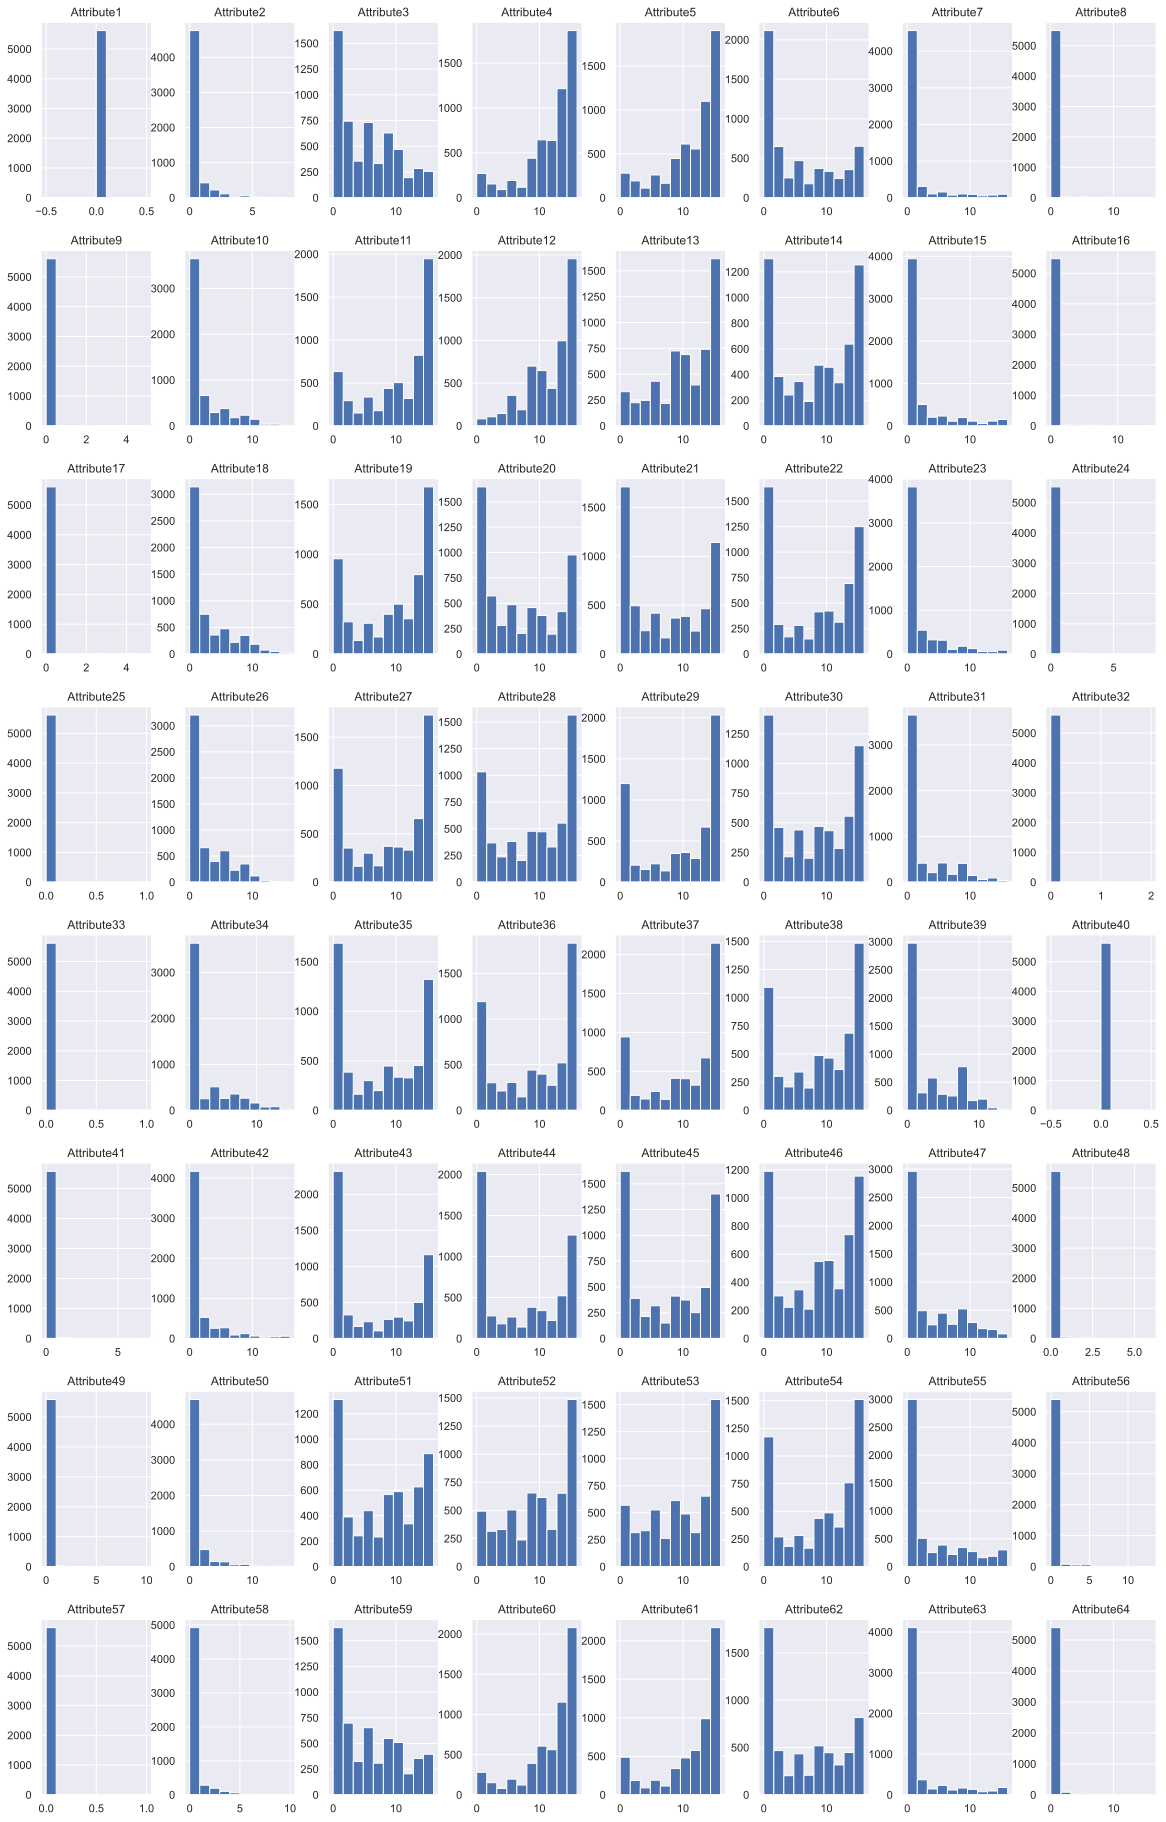

In [19]:
data.hist(figsize=(20, 32));

Багато значень `Attribute` має тільки 0 значеня. Можливо їх потрібно позбутися. А загалом фіч дуже багато, зменшимо їх кількість за допомогою `TSNE()`.

Розділимо датасет на фічі та таргет.

In [20]:
X_tsne = data.drop('class', axis=1).values
y_tsne = data['class'].copy().values

Створюємо нові фічі

In [21]:
tsne = TSNE(n_components=2, verbose=1, random_state=42)

In [22]:
W = tsne.fit_transform(X_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5620 samples in 0.000s...
[t-SNE] Computed neighbors for 5620 samples in 1.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5620
[t-SNE] Computed conditional probabilities for sample 2000 / 5620
[t-SNE] Computed conditional probabilities for sample 3000 / 5620
[t-SNE] Computed conditional probabilities for sample 4000 / 5620
[t-SNE] Computed conditional probabilities for sample 5000 / 5620
[t-SNE] Computed conditional probabilities for sample 5620 / 5620
[t-SNE] Mean sigma: 9.124381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.445122
[t-SNE] KL divergence after 1000 iterations: 1.246467


In [23]:
new_data = pd.DataFrame()
new_data["y"] = y_tsne
new_data["comp-1"] = W[:,0]
new_data["comp-2"] = W[:,1]

[Text(0.5, 1.0, 'NIST data T-SNE projection')]

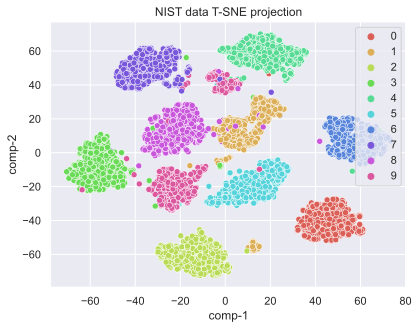

In [24]:
sns.scatterplot(x="comp-1", y="comp-2", hue=new_data.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=new_data).set(title="NIST data T-SNE projection")

На гафіку перетворених за допомогою `TSNE` фіч добре видно розділеня на класи. Є декілька маленьких груп що відокремлені від основних.

---
<a name="4"/>

### 4. Маштабування фіч
[зміст](#0)

Сплітимо датасет на фічі і таргет

In [25]:
X = new_data.drop('y', axis=1).values
y = new_data['y'].copy().values

Маштабуємо фічі за допомогою MinMaxScaler()

In [26]:
X_scaled = MinMaxScaler().fit_transform(X)

---
<a name="5"/>

### 5. Поділ датасету на train, valid, test
[зміст](#0)

In [27]:
# Функція спліту даних
def data_split_of_parts(X, y, test_size, valid_size=0):
    X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    if valid_size != 0:
        X_train, X_valid, y_train, y_valid = train_test_split(X_tr_val, y_tr_val, test_size=valid_size, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test

    else:
        return X_tr_val, X_test, y_tr_val, y_test

In [28]:
X_train, X_valid, X_test, y_train, y_valid, y_test = data_split_of_parts(X_scaled, y, 0.4, 0.25)

---
<a name="6"/>

### 6. Тренування базової моделі(гіперпараметри=дефолтні)
[зміст](#0)

In [29]:
clf_SVC_default = SVC(random_state=42).fit(X_train, y_train)

In [30]:
clf_SVC_default_pred = clf_SVC_default.predict(X_test)

In [31]:
clf_SVC_default.score(X_test, y_test)

0.9853202846975089

---
<a name="7"/>

### 7. Підбір гіперпараметрів
[зміст](#0)

In [32]:
SVC_parameters = {'kernel': ['rbf'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3,5,8],
                  'gamma': ['scale', 'auto'],
                  'tol': [0.001, 0.0001],
                  'decision_function_shape': ['ovr', 'ovo'],
                  'random_state': [42]}

Гіперпараметри: `kernel: "rbf", degree: 3, gamma: scale`

In [33]:
SVC_parameter_1 = {'kernel': ['rbf'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'random_state': [42]}

In [34]:
clf_SVC = SVC()
clf_SVC_bp_1 = GridSearchCV(clf_SVC, SVC_parameter_1).fit(X_valid, y_valid)

In [35]:
clf_SVC_bp_1_pred = clf_SVC_bp_1.predict(X_test)

In [36]:
clf_SVC_bp_1.score(X_test, y_test)

0.9853202846975089

In [37]:
clf_SVC_bp_1.best_params_

{'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}

Гіперпараметри: `kernel: "rbf", degree: 5, gamma: scale`

In [38]:
SVC_parameter_2 = {'kernel': ['rbf'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [5],
                  'gamma': ['scale'],
                  'random_state': [42]}

In [39]:
clf_SVC_bp_2 = GridSearchCV(clf_SVC, SVC_parameter_2).fit(X_valid, y_valid)

In [40]:
clf_SVC_bp_2_pred = clf_SVC_bp_2.predict(X_test)

In [41]:
clf_SVC_bp_2.score(X_test, y_test)

0.9853202846975089

In [42]:
clf_SVC_bp_2.best_params_

{'degree': 5, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}

Гіперпараметри: `kernel: "rbf", degree: 3, gamma: auto`

In [43]:
SVC_parameter_3 = {'kernel': ['rbf'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3],
                  'gamma': ['auto'],
                  'random_state': [42]}

In [44]:
clf_SVC_bp_3 = GridSearchCV(clf_SVC, SVC_parameter_3).fit(X_valid, y_valid)

In [45]:
clf_SVC_bp_3_pred = clf_SVC_bp_3.predict(X_test)

In [46]:
clf_SVC_bp_3.score(X_test, y_test)

0.9466192170818505

In [47]:
clf_SVC_bp_3.best_params_

{'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42}

Гіперпараметри: `kernel: "linear", degree: 3, gamma: scale`

In [48]:
SVC_parameter_4 = {'kernel': ['linear'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'random_state': [42]}

In [49]:
clf_SVC_bp_4 = GridSearchCV(clf_SVC, SVC_parameter_4).fit(X_valid, y_valid)

In [50]:
clf_SVC_bp_4_pred = clf_SVC_bp_4.predict(X_test)

In [51]:
clf_SVC_bp_4.score(X_test, y_test)

0.9466192170818505

In [52]:
clf_SVC_bp_4.best_params_

{'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 42}

Гіперпараметри: `kernel: "poly", degree: 3, gamma: scale`

In [53]:
SVC_parameter_5 = {'kernel': ['poly'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'random_state': [42]}

In [54]:
clf_SVC_bp_5 = GridSearchCV(clf_SVC, SVC_parameter_5).fit(X_valid, y_valid)

In [55]:
clf_SVC_bp_5_pred = clf_SVC_bp_5.predict(X_test)

In [56]:
clf_SVC_bp_5.score(X_test, y_test)

0.9470640569395018

In [57]:
clf_SVC_bp_5.best_params_

{'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 42}

Гіперпараметри: `kernel: "sigmoid", degree: 3, gamma: scale`

In [58]:
SVC_parameter_6 = {'kernel': ['sigmoid'], # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'random_state': [42]}

In [59]:
clf_SVC_bp_6 = GridSearchCV(clf_SVC, SVC_parameter_6).fit(X_valid, y_valid)

In [60]:
clf_SVC_bp_6_pred = clf_SVC_bp_6.predict(X_test)

In [61]:
clf_SVC_bp_6.score(X_test, y_test)

0.13745551601423486

In [62]:
clf_SVC_bp_6.best_params_

{'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'random_state': 42}

---
<a name="8"/>

### 8. Оцінка результатів
[зміст](#0)

Оцінимо результати навчання базових моделей, та моделей з підбором гіперпараметрів за допомогою `classification_report()`

Для дефолтної моделі

In [63]:
print(classification_report(y_test, clf_SVC_default_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.96      1.00      0.98       234
           2       1.00      1.00      1.00       209
           3       0.99      0.97      0.98       238
           4       1.00      0.99      0.99       240
           5       0.99      0.99      0.99       212
           6       0.99      1.00      0.99       225
           7       0.97      0.99      0.98       232
           8       0.99      0.98      0.98       215
           9       0.97      0.95      0.96       228

    accuracy                           0.99      2248
   macro avg       0.99      0.99      0.99      2248
weighted avg       0.99      0.99      0.99      2248



Для моделі з підібраними гіперпараметрами: `kernel: "rbf", degree: 3, gamma: scale`

In [64]:
print(classification_report(y_test, clf_SVC_bp_1_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      1.00      0.97       234
           2       1.00      1.00      1.00       209
           3       0.99      0.97      0.98       238
           4       1.00      0.99      0.99       240
           5       0.99      0.99      0.99       212
           6       0.99      1.00      0.99       225
           7       0.97      0.99      0.98       232
           8       0.99      0.98      0.98       215
           9       0.98      0.95      0.96       228

    accuracy                           0.99      2248
   macro avg       0.99      0.99      0.99      2248
weighted avg       0.99      0.99      0.99      2248



Для моделі з підібраними гіперпараметрами: `kernel: "rbf", degree: 5, gamma: scale`

In [65]:
print(classification_report(y_test, clf_SVC_bp_2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.95      1.00      0.97       234
           2       1.00      1.00      1.00       209
           3       0.99      0.97      0.98       238
           4       1.00      0.99      0.99       240
           5       0.99      0.99      0.99       212
           6       0.99      1.00      0.99       225
           7       0.97      0.99      0.98       232
           8       0.99      0.98      0.98       215
           9       0.98      0.95      0.96       228

    accuracy                           0.99      2248
   macro avg       0.99      0.99      0.99      2248
weighted avg       0.99      0.99      0.99      2248



Для моделі з підібраними гіперпараметрами: `kernel: "rbf", degree: 3, gamma: auto`

In [66]:
print(classification_report(y_test, clf_SVC_bp_3_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.93      0.89      0.91       234
           2       0.91      1.00      0.95       209
           3       0.97      0.97      0.97       238
           4       0.83      0.99      0.90       240
           5       0.97      1.00      0.98       212
           6       0.99      1.00      0.99       225
           7       0.95      0.99      0.97       232
           8       0.98      0.97      0.97       215
           9       0.98      0.68      0.80       228

    accuracy                           0.95      2248
   macro avg       0.95      0.95      0.95      2248
weighted avg       0.95      0.95      0.94      2248



Для моделі з підібраними гіперпараметрами: `kernel: "linear", degree: 3, gamma: scale`

In [67]:
print(classification_report(y_test, clf_SVC_bp_4_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.94      0.90      0.92       234
           2       0.91      1.00      0.95       209
           3       0.97      0.97      0.97       238
           4       0.83      0.99      0.90       240
           5       0.98      1.00      0.99       212
           6       0.99      1.00      0.99       225
           7       0.95      0.99      0.97       232
           8       0.98      0.96      0.97       215
           9       0.97      0.68      0.80       228

    accuracy                           0.95      2248
   macro avg       0.95      0.95      0.95      2248
weighted avg       0.95      0.95      0.94      2248



Для моделі з підібраними гіперпараметрами: `kernel: "poly", degree: 3, gamma: scale`

In [68]:
print(classification_report(y_test, clf_SVC_bp_5_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       0.96      0.99      0.97       234
           2       1.00      1.00      1.00       209
           3       0.99      0.97      0.98       238
           4       0.91      0.97      0.94       240
           5       0.99      0.99      0.99       212
           6       0.99      1.00      0.99       225
           7       0.96      0.99      0.97       232
           8       0.96      0.73      0.83       215
           9       0.75      0.83      0.79       228

    accuracy                           0.95      2248
   macro avg       0.95      0.95      0.95      2248
weighted avg       0.95      0.95      0.95      2248



Для моделі з підібраними гіперпараметрами: `kernel: "sigmoid", degree: 3, gamma: scale`

In [69]:
print(classification_report(y_test, clf_SVC_bp_6_pred))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33       215
           1       0.00      0.00      0.00       234
           2       0.00      0.00      0.00       209
           3       0.00      0.00      0.00       238
           4       0.00      0.00      0.00       240
           5       0.13      0.44      0.20       212
           6       0.00      0.00      0.00       225
           7       0.00      0.00      0.00       232
           8       0.00      0.00      0.00       215
           9       0.00      0.00      0.00       228

    accuracy                           0.14      2248
   macro avg       0.03      0.14      0.05      2248
weighted avg       0.03      0.14      0.05      2248



Як бачимо навіть дефолтна модель видає `score:0.99`. Кращі моделі з підібраними гіперпараметрами ведуть себе по різному. `Kernel` впливає на навчання. Добре описує наші дані: `rbf, poly, linear`. `sigmoid` показало поганий `score:0.14`. Параметр `degree` не дуже впливає на модель між 3 і 5 немає чуттєвоє різниці. Параметр `gamma` краще обирати `scale`. `auto` знижує score.

Загалом найкращі гіперпараметри виявились: `kernel: "rbf", degree: 3, gamma: scale`

### Дякую за увагу =)